## Synopsis of inpainting result

In [2]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
import os
from os.path import join
import pickle as pkl
import einops
import torch
import torch as th
from easydict import EasyDict as edict
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config, create_edm_new
# from rule_utils import get_rule_img, get_obj_list, get_rule_list
# from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from rule_new_utils import infer_rule_from_sample_batch, check_r3_r2_batch

In [4]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt 
%matplotlib inline
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [40]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_ids = heldout_id_dict['train_inputs_new.pt']  # [1, 16, 20, 34, 37]

In [52]:
from stats_plot_utils import saveallforms
figdir = "/n/home12/binxuwang/Github/DiffusionReasoning/Figures_CCN"

### EDM

In [53]:
expname = "WideBlnrX3_new_RAVEN10_abstract_20240412-1347"
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
DATASET = "RAVEN10_abstract"
expdir = join(exproot, expname)
# ckptdir = join(expdir, "checkpoints")
EDM_inpaint_dir = join(expdir, "inpaint_pilot")

In [54]:
df = pd.read_csv(join(EDM_inpaint_dir, "inpaint_rule_stats.csv"))

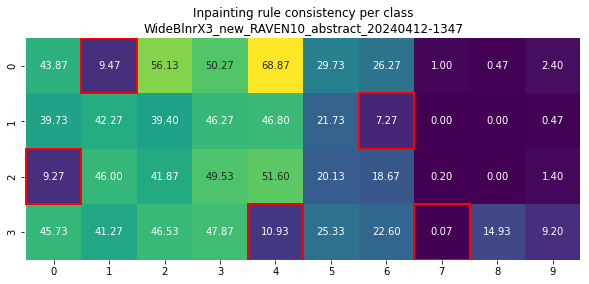

In [57]:
r3_per_class = df.groupby("iclass").agg({"consistent_r3": "mean"})
r3mat = r3_per_class.to_numpy().reshape(4,10)
plt.figure(figsize=(10, 4))
sns.heatmap(r3mat, annot=True, fmt=".2f", cmap="viridis", cbar=False)
for rule_id in heldout_ids:
    row = rule_id // 10
    col = rule_id % 10
    plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
plt.axis("equal")
plt.title(f"Inpainting rule consistency per class\n{expname}")
saveallforms(figdir, f"{expname}_inpaint_rule_consistency_per_class_heatmap", fmts=["png", "pdf"])

In [46]:
suffix = '_unif_baseline'
baseline_expname = "Uniform filling baseline"
df_rnd = pd.read_csv(join(EDM_inpaint_dir, f"inpaint_rule_stats{suffix}.csv"))

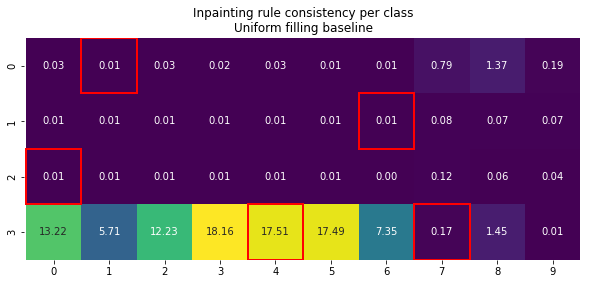

In [58]:
r3_per_class = df_rnd.groupby("iclass").agg({"consistent_r3": "mean"})
r3mat = r3_per_class.to_numpy().reshape(4,10)
plt.figure(figsize=(10, 4))
sns.heatmap(r3mat, annot=True, fmt=".2f", cmap="viridis", cbar=False)
for rule_id in heldout_ids:
    row = rule_id // 10
    col = rule_id % 10
    plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
plt.title(f"Inpainting rule consistency per class\n{baseline_expname}")
plt.axis("equal")
saveallforms(figdir, f"{baseline_expname}_inpaint_rule_consistency_per_class_heatmap", fmts=["png", "pdf"])

### DiT

In [48]:
DiTroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/DiT/results"
DiTexpname = "045-RAVEN10_abstract-uncond-DiT_S_1_20240311-1256"
expdir = join(DiTroot, DiTexpname)
DiT_inpaint_dir = join(expdir, "inpaint_pilot")

In [49]:
df_DiT = pd.read_csv(join(DiT_inpaint_dir, "inpaint_rule_stats.csv"))

In [50]:
df_DiT.consistent_r3.mean()

26.145666666666667

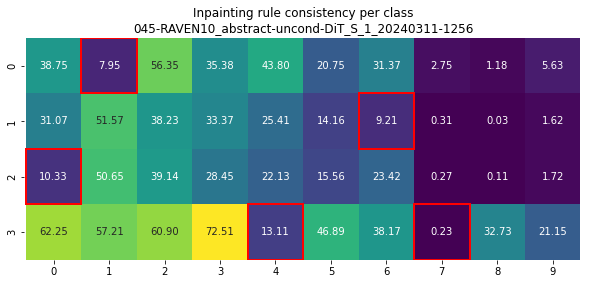

In [59]:
r3_per_class = df_DiT.groupby("iclass").agg({"consistent_r3": "mean"})
r3mat = r3_per_class.to_numpy().reshape(4,10)
plt.figure(figsize=(10, 4))
sns.heatmap(r3mat, annot=True, fmt=".2f", cmap="viridis", cbar=False)
for rule_id in heldout_ids:
    row = rule_id // 10
    col = rule_id % 10
    plt.gca().add_patch(Rectangle((col, row), 1, 1, fill=False, edgecolor='red', lw=2))
plt.title(f"Inpainting rule consistency per class\n{DiTexpname}")
plt.axis("equal")
saveallforms(figdir, f"{DiTexpname}_inpaint_rule_consistency_per_class_heatmap", fmts=["png", "pdf"])

### Strip Plot

In [21]:
def paired_strip_plot_multimsk(vecall1, vecall2, msks, pair_step=1, labels=["A", "B"], kwargs={}):
    if msks is None:
        msks = [np.ones(len(df), dtype=bool)]
    nmsks = len(msks)
    figh = plt.figure(figsize=[5, 6])
    for mi, msk in enumerate(msks):
        vec1 = vecall1[msk]
        vec2 = vecall2[msk]
        xjitter = mi + 0.1 * np.random.randn(len(vec1))
        plt.scatter(xjitter-pair_step/2, vec1, color="C0", label=labels[0] if mi == 0 else None, **kwargs)
        plt.scatter(xjitter+pair_step/2, vec2, color="C1", label=labels[1] if mi == 0 else None, **kwargs)
        plt.plot(pair_step*(np.arange(2)[:,None]-1/2)+xjitter[None,:],
                 np.stack((vec1, vec2)), color="k", alpha=0.1)
    # vec1 = df[msk][col1]
    # vec2 = df[msk][col2]
    # xjitter = 0.1 * np.random.randn(len(vec1))
    # figh = plt.figure(figsize=[5, 6])
    # plt.scatter(xjitter, vec1)
    # plt.scatter(xjitter+1, vec2)
    # plt.plot(np.arange(2)[:,None]+xjitter[None,:],
    #          np.stack((vec1, vec2)), color="k", alpha=0.1)
    # plt.xticks([0,1], [col1, col2])
    # tval, pval = ttest_rel_df(df, msk, col1, col2)
    # plt.title(f"tval={tval:.3f}, pval={pval:.1e} N={msk.sum()}")
    # plt.show()
    return figh

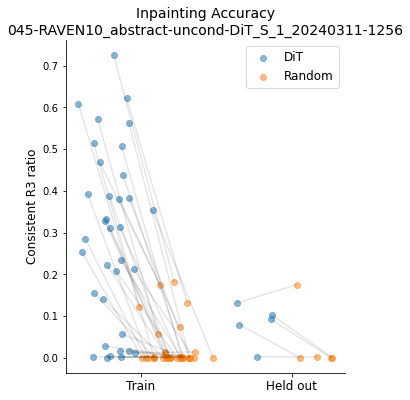

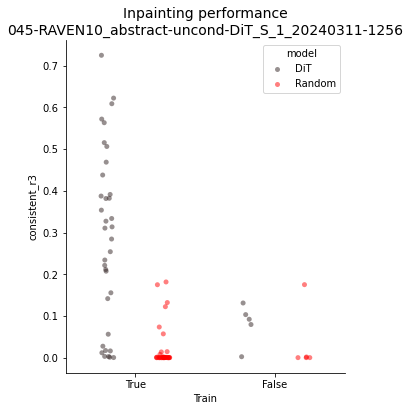

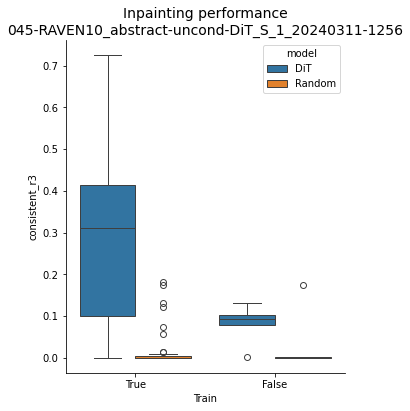

In [64]:
heldout_ids = [1, 16, 20, 34, 37]
train_msk = np.ones(40, dtype=bool)
train_msk[heldout_ids] = False
test_msk = ~train_msk
r3_per_class_tab = df_DiT.groupby("iclass").agg({"consistent_r3": "mean"}) / 100 # 40 classes array 
r3_per_class_rnd = df_rnd.groupby("iclass").agg({"consistent_r3": "mean"}) / 100 # 40 classes array 
r3_per_class_tab["Train"] = train_msk
r3_per_class_tab["model"] = "DiT"
r3_per_class_rnd["Train"] = train_msk
r3_per_class_rnd["model"] = "Random"
r3_per_class_cmb = pd.concat([r3_per_class_tab, r3_per_class_rnd], axis=0)
figh = paired_strip_plot_multimsk(r3_per_class_tab["consistent_r3"].to_numpy(), 
                                  r3_per_class_rnd["consistent_r3"].to_numpy(), 
                                  [train_msk, test_msk], pair_step=0.4, 
                                  labels=["DiT", "Random"], kwargs={"alpha": 0.5, "s": 36});
figh.gca().set_xticks([0, 1])
figh.gca().set_xticklabels(["Train", "Held out"],fontsize=12)
figh.gca().set_ylabel("Consistent R3 ratio", fontsize=12)
figh.gca().set_title(f"Inpainting Accuracy\n{DiTexpname}", fontsize=14)
figh.gca().legend(fontsize=12)
saveallforms(figdir, "DiT_S_1_inpainting_accuracy_paired_strip", figh, ["png", "pdf"])
figh.show()
plt.figure(figsize=(5, 6))
sns.stripplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model", jitter=0.1, palette='dark:red', order=[True, False],
              alpha=0.5, dodge=True) 
plt.title(f"Inpainting performance\n{DiTexpname}", fontsize=14)
saveallforms(figdir, "DiT_S_1_inpainting_accuracy_strip", figh, ["png", "pdf"])
plt.show()
plt.figure(figsize=(5, 6))
sns.boxplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model", linewidth=1, order=[True, False],) # color="white", 
plt.title(f"Inpainting performance\n{DiTexpname}", fontsize=14)
saveallforms(figdir, "DiT_S_1_inpainting_accuracy_box", figh, ["png", "pdf"])
plt.show()

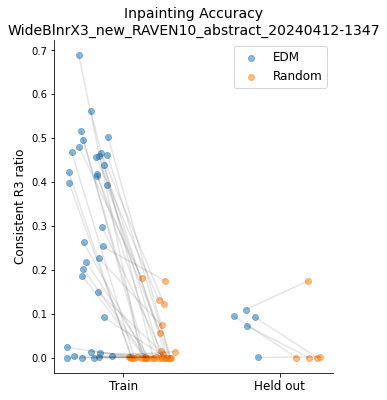

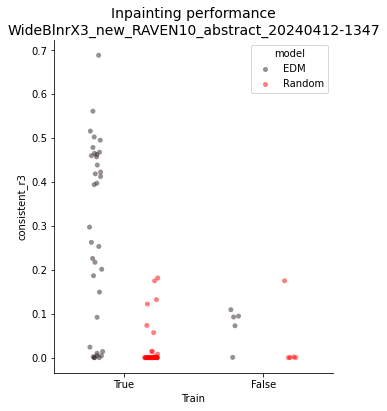

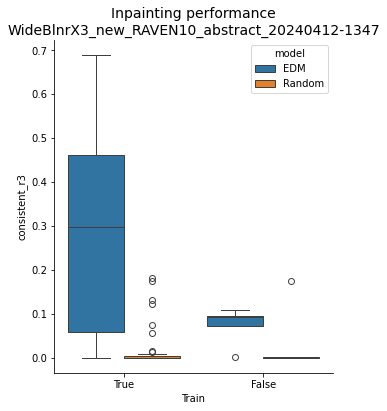

In [65]:
heldout_ids = [1, 16, 20, 34, 37]
train_msk = np.ones(40, dtype=bool)
train_msk[heldout_ids] = False
test_msk = ~train_msk
r3_per_class_tab = df.groupby("iclass").agg({"consistent_r3": "mean"}) / 100 # 40 classes array 
r3_per_class_rnd = df_rnd.groupby("iclass").agg({"consistent_r3": "mean"}) / 100 # 40 classes array 
r3_per_class_tab["Train"] = train_msk
r3_per_class_tab["model"] = "EDM"
r3_per_class_rnd["Train"] = train_msk
r3_per_class_rnd["model"] = "Random"
r3_per_class_cmb = pd.concat([r3_per_class_tab, r3_per_class_rnd], axis=0)
figh = paired_strip_plot_multimsk(r3_per_class_tab["consistent_r3"].to_numpy(), 
                                  r3_per_class_rnd["consistent_r3"].to_numpy(), 
                                  [train_msk, test_msk], pair_step=0.4, 
                                  labels=["EDM", "Random"], kwargs={"alpha": 0.5, "s": 36});
figh.gca().set_xticks([0, 1])
figh.gca().set_xticklabels(["Train", "Held out"],fontsize=12)
figh.gca().set_ylabel("Consistent R3 ratio", fontsize=12)
figh.gca().set_title(f"Inpainting Accuracy\n{expname}", fontsize=14)
figh.gca().legend(fontsize=12)
saveallforms(figdir, "EDM_Wide_inpainting_accuracy_paired_strip", figh, ["png", "pdf"])
figh.show()
plt.figure(figsize=(5, 6))
sns.stripplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model", jitter=0.1, palette='dark:red', order=[True, False],
              alpha=0.5, dodge=True) 
plt.title(f"Inpainting performance\n{expname}", fontsize=14)
saveallforms(figdir, "EDM_Wide_inpainting_accuracy_strip", figh, ["png", "pdf"])
plt.show()
plt.figure(figsize=(5, 6))
sns.boxplot(data=r3_per_class_cmb, x="Train", y="consistent_r3", hue="model", linewidth=1, order=[True, False],) # color="white", 
plt.title(f"Inpainting performance\n{expname}", fontsize=14)
saveallforms(figdir, "EDM_Wide_inpainting_accuracy_box", figh, ["png", "pdf"])
plt.show()

<Axes: xlabel='iclass', ylabel='consistent_r3'>

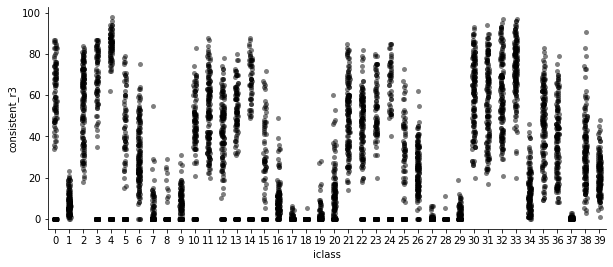

In [25]:
heldout_ids = [1, 16, 20, 34, 37]
r3_per_class = df_DiT.groupby("iclass").agg({"consistent_r3": "mean"}) # 40 classes array 
# plot 35 vs 5, mean and scatter
plt.figure(figsize=(10, 4))
sns.stripplot(data=df_DiT, x="iclass", y="consistent_r3", jitter=0.1, color="black", alpha=0.5)
